<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Thymio-Project" data-toc-modified-id="Thymio-Project-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Thymio Project</a></span></li><li><span><a href="#Complete-Program" data-toc-modified-id="Complete-Program-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Complete Program</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#define-the-state-machine" data-toc-modified-id="define-the-state-machine-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>define the state machine</a></span><ul class="toc-item"><li><span><a href="#define-the-Robot-object" data-toc-modified-id="define-the-Robot-object-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>define the Robot object</a></span></li><li><span><a href="#Define-the-statefunctions" data-toc-modified-id="Define-the-statefunctions-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Define the statefunctions</a></span></li></ul></li><li><span><a href="#Initilization" data-toc-modified-id="Initilization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Initilization</a></span></li><li><span><a href="#Map-generation" data-toc-modified-id="Map-generation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Map generation</a></span></li></ul></li><li><span><a href="#Connecting-the-Thymio" data-toc-modified-id="Connecting-the-Thymio-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Connecting the Thymio</a></span></li><li><span><a href="#import-the-pathplanning-class" data-toc-modified-id="import-the-pathplanning-class-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>import the pathplanning class</a></span></li></ul></div>

# Thymio Project







In [1]:
pip install pyserial

Note: you may need to restart the kernel to use updated packages.


# Complete Program


## Imports
Import all the libraries needed to run the main program

In [1]:
#import standart libraries
import os
import sys
import time
import serial
import numpy as np
from numpy import linalg as LNG 
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image

%matplotlib inline

# Adding the src folder in the current directory as it contains the script
# with the Thymio class and all the files with the group generated functions and classes
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio
#import functions made by group
from pathPlanning import pathPlaning
import test_vision
import ANN
import robot_control
import sys

IndentationError: unindent does not match any outer indentation level (ANN.py, line 98)

## define the state machine
In this section the different states are defined as in the state machine graph shown earlier. The functions in this sections are named like the states they represent and they wrap the functions imported from the pathPlanning.py, test_vision.py,ANN.py and robot_control.py. 

### define the Robot object
This object contains all the variables needed in the state machine to make decisions.

In [3]:
class stateNames_t:
    def __init__(self):
        self.goalKnown='goalKnown'
        self.planning='planning'
        self.planAcuired='planAcuired'
        self.newPath='newpath'
        self.checkingPath='checkingPath'
        self.underWay='underWay'
        self.obstacleAvoidance='obstalceAvoidance'
        self.goalReached='goalReached'
class FSMHelper:
    def __init__(self,thymio,kidnappingDistance,currentRobotPosition,equalTolerance):
        self.kidnapDistance=kidnappingDistance
        self.tolerance=equalTolerance
        self.currentPosition=currentRobotPosition
        self.newPositionEstimate=0    
        self.thymio=thymio      
        self.obstacleDetected=False
        self.doStop=False
        self.goalReached=True
        self.goal=np.zeros((2,1))
        self.pathToFollow
        self.FSMStates=states()

        

### Define the statefunctions
In this section the different functions used to represent the states of the state machine are defined. Each function takes the FSMHelper object to make the decisions which state is the next.

In [4]:
def goalKnown(robot):
    if(LNG.norm(np.subtract(robot.currentGoal,robot.newGoal))>robot.tolerance):
        robot.doStop=True
        robot.currentGoal=robot.newGoal.copy()     
        return robot.FSMStates.planning
    else:
        return robot.FSMStates.planAccuired
def planning(robot):
    robot.pathPlanner.setGoal(robot.currentGoal)
    return robot.FSMStates.planAccuired
def planAccuired(robot):
    if(LNG.norm(np.subtract(robot.currentPosition,robot.newPositionEstimate))>robot.kidnappingDistance):
        robot.pathPlanner.setStart(robot.newPositionEstimate)
        robot.currentPosition=robot.newPositionEstimate
        return robot.FSMStates.newPath
    else:
        return robot.FSMStates.checkingPath
def newPath(robot):#pathPlanner,pathToFollow
    robot.pathToFollow=robot.pathPlanner.getOptimizedPath()
    return robot.FSMStates.checkingPath
    
def checkingPath(robot):
    if(len(pathToFollow)):
        robot_control.path_following(robot.pathToFollow)
        return robot.FSMStates.underWay
    else:  
        robot.doStop=True
        return robot.FSMStates.goalReached
def underWay(robot):
    if(robot.obstacleDetected==True):
        return robot.FSMStates.obstacleAvoidance
    else:
        ##toDo: call vision to get goal
        ##goal=
        return robot.FSMStates.goalKnown
def avoidObstacle(robot):     
    ANN.run_ann_without_memory(robot.thymio)
    return robot.FSMStates.checkingPath 
def goalReached(robot):
    robot.goalReached=True
    
    
#define the concrete stateName object to make the dictionary for the actual state machine
stateName=stateNames_t()
switch = {
    stateName.goalKnown        : goalKnown,
    stateName.planning         : planning,
    stateName.planAcuired      : planAccuired,
    stateName.newPath          : newPath,
    stateName.checkingPath     : checkingPath,
    stateName.underWay         : underWay,
    stateName.obstacleAvoidance: avoidObstacle,
    stateName.goalReached      : goalReached,
}
currentState=stateName.goalKnown
futureState=stateName.goalKnown

TypeError: __init__() takes 0 positional arguments but 1 was given

## Initilization
The first steps are to try to connect to the camera and the thymio and then set different decision variables

In [ ]:
th = Thymio.serial(port="COM5", refreshing_rate=0.1)
#toDo: connect to camera

## Map generation
In this section the vision part is used to generate a map and then define a pathfinding object for that map. These section represents the 3 first states, since that division can be done in a Notebook

In [9]:
##replace static loading with loading from camera



##make map



##placeholder
pil_imgray = Image.open('Images/obstaclesTestMap.jpg').convert('LA')
img = np.array(list(pil_imgray.getdata(band=0)), float)
img.shape = (pil_imgray.size[1], pil_imgray.size[0])
img=img<200
occupancyGrid=img.astype(int)


##generate pathplanning object from occupancy grid
pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)
startPosition=np.array([0,0])

Mainpart of the State machine

In [ ]:
robotStatus=FSMHelper(th,10,startPosition,)

while(robotStatus.goalReached==False):         #main execution loop
    stateToExecute=switch.get(currentState)
    futureState=stateToExecute(robotStatus)
    
    #doRobotControl here
    
    
    #do

    currentState=futureState

[[10. 19. 22. 48. 60. 80. 90.]
 [10. 10. 13. 13. 25. 25. 15.]]


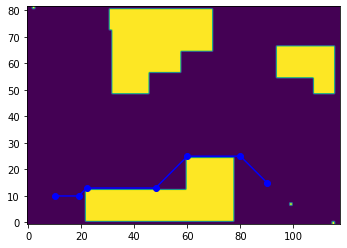

In [10]:
goal=np.array([90,15])
start=np.array([10,10])
pathPlanner.setGoal(goal)
pathPlanner.setStart(start)
path=pathPlanner.getOptimizedPath()
print(path)
plt.imshow(occupancyGrid,origin='lower')
plt.plot(path[0], path[1], marker="o", color = 'blue');
plt.show()

# Connecting the Thymio



In [ ]:
#th = Thymio.serial(port="COM5", refreshing_rate=0.1)

# import the pathplanning class

In [ ]:
from pathPlanning import pathPlaning

In [ ]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax
#Creating the grid
max_val = 50 # Size of the map

fig, ax = create_empty_plot(max_val)

# Creating the occupancy grid
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(max_val, max_val) * 20 # Create a grid of 50 x 50 random values
cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

# Converting the random values into occupied and free cells
limit = 12 
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");


In [ ]:
from timeit import default_timer as timer

In [ ]:
start = (0,0)
goal = (43,33)
startTimer=timer()
test=pathPlaning(occupancy_grid.copy(),1,1)
test.setGoal(goal)
test.setStart(start)
path=np.array(test.getPath())
endTimer=timer()
print("Path",path)
print("Time:",endTimer-startTimer)
path = np.array(path).reshape(-1, 2).transpose()

distanceGrid=test.getDistanceMap()
fig_astar, ax_astar = create_empty_plot(max_val)
fillUp=np.zeros_like(occupancy_grid.transpose())
maxValue=np.amax(distanceGrid.transpose())
print("MaxValue",maxValue)
pic=np.dstack((occupancy_grid.transpose(),np.divide(distanceGrid.transpose(),maxValue),fillUp))#the multiplication of the divition by 35 is used to make the distance grid visible. 35 was chosen by testing
ax_astar.imshow(pic)
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');


Test the input of a faulty start

In [ ]:
start = (0,5)
goal = (43,33)
startTimer=timer()
test=pathPlaning(occupancy_grid.copy(),1,1)
test.setGoal(goal)
test.setStart(start)
path=np.array(test.getPath())

check with different start

In [ ]:
start = (20,40)
goal = (43,33)
startTimer=timer()
test=pathPlaning(occupancy_grid.copy(),1,1)
test.setGoal(goal)
test.setStart(start)
path=np.array(test.getPath())
endTimer=timer()
print("time to find path:",endTimer-startTimer)
path = np.array(path).reshape(-1, 2).transpose()
#print("Path",path)
distanceGrid=test.getDistanceMap()
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(distanceGrid.transpose())
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');

In [ ]:
def optimizePath(originalPath,tolerance):
    edgePoints = [tuple(originalPath[:,0])]
    movmentOld=np.array([0, 0])
    movmentNew=np.array([0, 0])
    
    for pointNumber in range(1,originalPath.shape[1]):
        movmentNew=originalPath[:,pointNumber]-originalPath[:,pointNumber-1]
        if(abs(movmentNew[0]-movmentOld[0])>tolerance or abs(movmentNew[1]-movmentOld[1])>tolerance):
            if(tuple(originalPath[:,pointNumber-1]) not in edgePoints):
                edgePoints.append(tuple(originalPath[:,pointNumber-1]))
            #print("OldPoint:{}, New Point:{} , Difference1: {}, Difference2: {}".format(tuple(originalPath[:,pointNumber-1]),tuple(originalPath[:,pointNumber]),abs(movmentNew[0]-movmentOld[0]),abs(movmentNew[1]-movmentOld[1])))
        movmentOld=movmentNew
    #print(edgePoints)
    edgePoints.append(tuple(originalPath[:,-1]))
    return edgePoints

different goal

In [ ]:
start = (0,0)
goal = (5,46)
startTimer=timer()
test=pathPlaning(occupancy_grid.copy(),1,1)
test.setGoal(goal)
test.setStart(start)
path=np.array(test.getPath())
endTimer=timer()
print(endTimer-startTimer)
path = np.array(path).reshape(-1, 2).transpose()
#print("Path",path)
distanceGrid=test.getDistanceMap()
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(distanceGrid.transpose())
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');

In [ ]:
optimalPath=test.getOptimizedPath()

optimalPath=np.array(optimalPath)
optimalPath = np.array(optimalPath).reshape(-1, 2).transpose()
path=np.array(test.getPath())
path = np.array(path).reshape(-1, 2).transpose()
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)
ax_astar.plot(optimalPath[0],optimalPath[1], marker="o", color = 'blue');
print(optimalPath)

In [ ]:

from matplotlib import pyplot
from PIL import Image
pil_imgray = Image.open('Images/obstacles.jpg').convert('LA')
img = np.array(list(pil_imgray.getdata(band=0)), float)
img.shape = (pil_imgray.size[1], pil_imgray.size[0])

plt.imshow(img)
img=img<200
img=img.astype(int)
pyplot.imshow(img)
pyplot.show()
print(np.amax(img))


In [ ]:
start = (0,0)
goal = (5,46)
startTimer=timer()
test=pathPlaning(img.copy(),1,1)
test.setGoal(goal)
test.setStart(start)
path=np.array(test.getPath())
endTimer=timer()
print(endTimer-startTimer)
path = np.array(path).reshape(-1, 2).transpose()